<a href="https://colab.research.google.com/github/corwindark/5000-lab-1.2/blob/main/dl_ens_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Setup - Run Every Time

In [1]:
# TENSORFLOW
import tensorflow as tf
print("TENSORFLOW VERSION:",tf.__version__)

# PYTORCH
import torch
print("PYTORCH VERSION:",torch.__version__)

# KERAS
import keras;
print("KERAS VERSION:",keras.__version__)

TENSORFLOW VERSION: 2.15.0
PYTORCH VERSION: 2.1.0+cu121
KERAS VERSION: 2.15.0


In [2]:
print(torch.cuda.is_available())

True


In [3]:
# GET SYSTEM INFO
# code modified from: https://stackoverflow.com/questions/110362/how-can-i-find-the-current-os-in-python

import platform
import multiprocessing
import sys
import psutil

def linux_distribution():
  try:
    return platform.linux_distribution()
  except:
    return "N/A"

def dist():
  try:
    return platform.dist()
  except:
    return "N/A"

num_cores=multiprocessing.cpu_count()

print("""
Python version: %s
dist: %s
num_cores: %s
linux_distribution: %s
system: %s
machine: %s
platform: %s
uname: %s
version: %s
RAM: %s
""" % (
sys.version.split('\n'),
str(dist()),
num_cores,
linux_distribution(),
platform.system(),
platform.machine(),
platform.platform(),
platform.uname(),
platform.version(),
psutil.virtual_memory().total*10**(-9.)
))

# print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))


Python version: ['3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]']
dist: N/A
num_cores: 2
linux_distribution: N/A
system: Linux
machine: x86_64
platform: Linux-6.1.58+-x86_64-with-glibc2.35
uname: uname_result(system='Linux', node='d6fd48fcc495', release='6.1.58+', version='#1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023', machine='x86_64')
version: #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
RAM: 13.60945152



In [4]:
torch.cuda.device_count()
torch.cuda.get_device_properties(0).total_memory

15835660288

In [5]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

pd.options.mode.chained_assignment = None


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [6]:
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "statsforecast"])

0

In [7]:
from statsforecast import StatsForecast
from statsforecast.models import AutoCES, AutoARIMA, AutoETS, DynamicOptimizedTheta
import numpy as np
import time

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Old Stat Functions

In [ ]:
def crossValidation(train, test, window, outputFrame, modelName, predReturnFunction):

    totalPredictions = pd.Series(dtype = 'float64')
    windows = len(test) // window

    predictionIndex = 0

    for i in range(0, windows):
        # debug
        #print("Window: ", i, "Method: ", modelName)

        # How many observations to move forward each frame
        addNum = i * window
        # Combine training data with additional test window
        intermediateData = pd.concat([train, test[:addNum]])
        # Generate prediction of the given window size
        prediction = predReturnFunction(intermediateData, window)
        #print(prediction)
        # Check if we have multiple predictions in the window
        if len(prediction) > 1:
            # Store each predicted value with a loop
            for j in range(0,window):

                # Store in the prediction-comparison frame
                outputFrame[modelName][predictionIndex] = prediction[j]

                # Move to next open spot
                predictionIndex += 1
        else:

            outputFrame[modelName][predictionIndex] = prediction[0]
            predictionIndex += 1


In [ ]:
def stat_test_wrapper(seriesTrain, seriesTest, testDF,  test_out_size = 100, window_size = 1):
    # Set the number of observations to be included in the test set

  testDFCopy = testDF.copy()

  tempTest = seriesTest[:test_out_size]

  # Auto Arima
  crossValidation(seriesTrain, tempTest, window_size, testDFCopy, 'auto_arima', aaPredFunction)

  crossValidation(seriesTrain, tempTest, window_size, testDFCopy, 'complex_smoothing', cesPredFunction)

  #crossValidation(seriesTrain, tempTest, window_size, testDFCopy, 'auto_ets', etsPredFunction)

  crossValidation(seriesTrain, tempTest, window_size, testDFCopy, 'dyn_theta', dotPredFunction)




  plot2 = testDFCopy.iloc[0:test_out_size,:]

  preds = plot2.loc[:,['auto_arima', 'complex_smoothing', 'dyn_theta']]
  # ensemble methods
  plot2.loc[:,'mean_ens'] = preds.mean(axis = 1)
  plot2.loc[:,'median_ens'] = preds.median(axis = 1)


  plot2.loc[:,'auto_arima'] = abs( plot2.loc[:,'auto_arima'] - plot2.loc[:,'Price'] )
  # auto ets is not very good apparently
  #plot2.loc[:,'auto_ets'] = abs( plot2.loc[:,'auto_ets'] - plot2.loc[:,'Price'] )
  plot2.loc[:,'complex_smoothing'] = abs( plot2.loc[:,'complex_smoothing'] - plot2.loc[:,'Price'] )
  plot2.loc[:,'dyn_theta'] = abs( plot2.loc[:,'dyn_theta'] - plot2.loc[:,'Price'] )
  plot2.loc[:,'mean_ens'] = abs( plot2.loc[:,'mean_ens'] - plot2.loc[:,'Price'] )
  plot2.loc[:,'median_ens'] = abs( plot2.loc[:,'median_ens'] - plot2.loc[:,'Price'] )



  # get the index as a column for plotting
  plot2 = plot2.reset_index()

  errorDat = plot2.copy()

  names = ['auto_arima', 'dyn_theta', 'complex_smoothing']
  errorDat['optimal'] = errorDat[names].idxmin(axis="columns")

  #print("reached loop")
  """
  for index in range(0, errorDat.shape[0]):
      #print(index)

      predictionErrors = errorDat.loc[index,['auto_arima', 'auto_ets', 'dyn_theta', 'complex_smoothing'] ]

      #print(predictionErrors)

      #print(min(abs(predictionErrors)))
      #errorDat.loc[index ,'optimal'] = min(abs(predictionErrors))
  """



  return testDFCopy, errorDat

In [ ]:
def aaPredFunction(dataIn, windowSize):
    model = AutoARIMA()
    fit1 = model.fit(y = np.concatenate(dataIn.to_numpy()))
    prediction = fit1.predict(h = windowSize)
    return prediction.get('mean')


def cesPredFunction(dataIn, windowSize):
    model = AutoCES()
    fit1 = model.fit(y = np.concatenate(dataIn.to_numpy()))
    predictionList = fit1.predict(windowSize)
    return predictionList.get('mean')

def etsPredFunction(dataIn, windowSize):
    model = AutoETS()
    fit1 = model.fit(y = np.concatenate(dataIn.to_numpy()))
    predictionList = fit1.predict(windowSize)
    return predictionList.get('mean')

def dotPredFunction(dataIn, windowSize):
    model = DynamicOptimizedTheta()
    fit1 = model.fit(y = np.concatenate(dataIn.to_numpy()))
    predictionList = fit1.predict(windowSize)
    return predictionList.get('mean')



# Set the number of observations to be included in the test set
test_out_size = 200

tempTest = seriesTest[:test_out_size]


In [ ]:


def prep_ticker(ticker, start_date = '2022-06-01', end_date = '2023-09-30', intervals = '60m', split = True, train_size = 2000, model_list = ['auto_arima', 'dyn_theta', 'auto_ets', 'complex_smoothing']):
  data = yf.download(ticker,start_date, end_date, interval = intervals)
  #print(data.head())
  data.reset_index(inplace = True)


  data_train = data[:train_size]
  data_test = data[train_size:]

  test_size = len(data_test)


  data_test = data_test[["Datetime", "Close"]]
  data_train = data_train[["Datetime", "Close"]]

  seriesTrain = data_train.set_index('Datetime')
  seriesTest = data_test.set_index('Datetime')

  testResultsDF = pd.DataFrame(index = range(test_size))
  testResultsDF['Price'] = 0

  #print(data.head())

  # Get a clean format for close prices
  for i in range(0,test_size):
      testResultsDF['Price'][i] = seriesTest.values[i][0]


  # Initialize empty cells for the statistical forecasts
  for modeltype in model_list:
    testResultsDF[modeltype] = 0

  return testResultsDF, seriesTrain, seriesTest

# Old Stat Examples


In [ ]:

data = yf.download('SPY','2022-06-01','2023-09-30', interval ="60m")
%matplotlib inline

data['Adj Close'].plot()
plt.ion()
print(data)

data.reset_index(inplace = True)
print(data.head())

In [ ]:
train_size = 2000

data_train = data[:train_size]
data_test = data[train_size:]

test_size = len(data_test)


data_test = data_test[["Datetime", "Close"]]
data_train = data_train[["Datetime", "Close"]]

seriesTrain = data_train.set_index('Datetime')
seriesTest = data_test.set_index('Datetime')

cv_data = data[['Close']]

In [ ]:
# Let's reformat the test data into a dataframe we can add our predictions to

testResultsDF = pd.DataFrame(index = range(test_size))
testResultsDF['Price'] = 0
# Get a clean format for close prices
for i in range(0,test_size):
    testResultsDF['Price'][i] = seriesTest.values[i][0]


# Initialize empty cells for the statistical forecasts
testResultsDF['auto_arima'] = 0
testResultsDF['dyn_theta'] = 0
#testResultsDF['auto_ets'] = 0
testResultsDF['complex_smoothing'] = 0

In [ ]:

# Auto Arima
crossValidation(seriesTrain, tempTest, 1, testResultsDF, 'auto_arima', aaPredFunction)

crossValidation(seriesTrain, tempTest, 1, testResultsDF, 'complex_smoothing', cesPredFunction)

crossValidation(seriesTrain, tempTest, 1, testResultsDF, 'auto_ets', etsPredFunction)

crossValidation(seriesTrain, tempTest, 1, testResultsDF, 'dyn_theta', dotPredFunction)


In [ ]:
print(testResultsDF)

plot1 = testResultsDF.iloc[0:test_out_size,:]

# get the index as a column for plotting
plot1 = plot1.reset_index()

plot1 = pd.melt(plot1, id_vars = ['index'], value_vars =  ['auto_arima', 'auto_ets', 'complex_smoothing', 'dyn_theta', 'Price'])

print(plot1)

sns.lineplot(plot1, x = 'index', y = 'value', hue = 'variable')

In [ ]:

plot1 = testResultsDF.iloc[0:test_out_size,:]

# get the index as a column for plotting
plot1 = plot1.reset_index()

plot1 = pd.melt(plot1, id_vars = ['index'], value_vars =  ['auto_arima', 'auto_ets', 'complex_smoothing', 'dyn_theta', 'Price'])

print(plot1)

sns.lineplot(plot1, x = 'index', y = 'value', hue = 'variable')

In [ ]:
print(testResultsDF)

plot2 = testResultsDF.iloc[0:test_out_size,:]

plot2['auto_arima'] = plot2['auto_arima'] - plot2['Price']
plot2['auto_ets'] = plot2['auto_ets'] - plot2['Price']
plot2['complex_smoothing'] = plot2['complex_smoothing'] - plot2['Price']
plot2['dyn_theta'] = plot2['dyn_theta'] - plot2['Price']





# get the index as a column for plotting
plot2 = plot2.reset_index()

errorDat = plot2.copy()

plot2 = pd.melt(plot2, id_vars = ['index'], value_vars =  ['auto_arima', 'auto_ets', 'complex_smoothing', 'dyn_theta'])

sns.barplot(plot2, x = 'index', y = 'value', hue = 'variable')

In [ ]:
print(AAPLerrors.head())
print(AAPLerrors['optimal'].value_counts() )

print(AAPLerrors['auto_arima'].mean())
print(AAPLerrors['dyn_theta'].mean())
print(AAPLerrors['complex_smoothing'].mean())
print(AAPLerrors['mean_ens'].mean())

optimals = ['auto_arima', 'dyn_theta', 'complex_smoothing']
print(AAPLerrors[optimals].min(axis="columns").mean())


In [ ]:
AAPLpreds, AAPLerrors = stat_test_wrapper(trainSeriesAAPL, testSeriesAAPL, testResultsAAPL, 25, 1)


In [ ]:
errorDat['optimal'] = 0

for index in range(0, errorDat.shape[0]):
   # print(index)
    predictionErrors = errorDat.loc[:,('auto_arima', 'auto_ets', 'dyn_theta', 'complex_smoothing') ]

    #print(predictionErrors.min())

    errorDat.loc[index ,'optimal'] = min(predictionErrors)

errorDat

In [ ]:
print(qqqerrors.head())
print(qqqerrors['optimal'].value_counts() )
# QQQ, 22-6-1 to 23-9-30, 1hr,
# > 5-1 is auto_arima 4, complex smoothing 1
# > 100-1 is auto_arima 50, complex smoothing 44, dyn_theta 6
# > 200-20 is auto_arima 41, complex_smoothing 111, dyn_theta 48
# > 200-50 is auto_arima 18, c_s 92, dyn_theta 90
# > 200-100 is a_a 60, c_s 78, d_t 62
# AAPL, 22-6-1 to 23-9-30, 1hr,
# 100 - 1 is a_a 42, c_s 51, d_t 7





```
# This is formatted as code
```

# New DL Functions

In [ ]:
# Getting more different financial datasets


def prep_ticker(ticker, start_date = '2022-06-01', end_date = '2023-09-30', intervals = '60m', split = True, train_size = 2000):
  data = yf.download(ticker,start_date, end_date, interval = intervals)

  #print(data.head)

  data.reset_index(inplace = True)

  if split == True:
    data_train = data[:train_size]
    data_test = data[train_size:]

    test_size = len(data_test)


    data_test = data_test[["Datetime", "Close"]]
    data_train = data_train[["Datetime", "Close"]]

    seriesTrain = data_train.set_index('Datetime')
    seriesTest = data_test.set_index('Datetime')


    return seriesTrain, seriesTest

  elif split == False:
    data_out = data

    data_out = data_out[["Datetime", "Close"]]

    seriesOut = data_out.set_index('Datetime')


    return seriesOut




In [ ]:
def new_aaPredFunction(dataIn, windowSize):
    model = AutoARIMA()
    fit1 = model.fit(dataIn)
    prediction = fit1.predict(h = windowSize)
    return prediction.get('mean')


def new_cesPredFunction(dataIn, windowSize):
    model = AutoCES()
    fit1 = model.fit(dataIn)
    predictionList = fit1.predict(windowSize)
    return predictionList.get('mean')

def new_etsPredFunction(dataIn, windowSize):
    model = AutoETS()
    fit1 = model.fit(dataIn)
    predictionList = fit1.predict(windowSize)
    return predictionList.get('mean')

def new_dotPredFunction(dataIn, windowSize):
    model = DynamicOptimizedTheta()
    fit1 = model.fit(dataIn)
    predictionList = fit1.predict(windowSize)
    return predictionList.get('mean')

In [ ]:
def stat_true_window_cross_val(unsplitdata, model_names, predReturnFunctions, train_window = 10, test_window = 1, nn_task = 'regression'):
    totalPredictions = pd.Series(dtype = 'float64')
    windows = len(unsplitdata) // (train_window + test_window)
    columns = train_window + (test_window * (1 + len(model_names)))

    pred_df = np.zeros([windows, columns])
    print(pred_df.shape)

    unsplitdata = np.array(unsplitdata)
    unsplitdata = unsplitdata.reshape((unsplitdata.shape[0],))
    print(unsplitdata.shape)

    # indexes loop through the data
    predictionIndex = 0
    startindex = 0

    for i in range(0, windows):
        # debug
        #print("Window: ", i)

        train_window_dat = unsplitdata[startindex:(startindex+train_window)]
        #print(train_window_dat)
        test_window_dat = unsplitdata[(startindex+train_window ): (test_window + startindex+train_window)]

        startindex = startindex + train_window + test_window

        #print(pred_df[i,0:train_window])
        #print(pred_df[i,0:train_window].shape)

        #print(train_window_dat.shape)
        #print( train_window_dat.reshape((train_window,)).shape)

        pred_df[i,0:train_window] = np.reshape(train_window_dat, [train_window])
        pred_df[i,(train_window):(train_window + test_window)] = test_window_dat

        for modnum, modelfunction in enumerate(predReturnFunctions):
          # account for how many columns in output array over to shift for this model
          # add 1 to fit the real values
          #print(modnum)
          offset = ((modnum + 1) * test_window) + train_window

          # Generate prediction of the given window size
          prediction = modelfunction(train_window_dat, test_window)
          #print(prediction[0])

          # Check if we have multiple predictions in the window
          if len(prediction) > 1:
              # Store each predicted value with a loop
              for j in range(0,test_window):

                  # Store in the prediction-comparison frame
                  pred_df[i,j + offset] = prediction[j]

          else:

              pred_df[i,offset] = prediction[0]

    # currently configured to split up data into 3 matrices instead of returning together
    x_windows = pred_df[:,0:train_window]
    real_ys = pred_df[:,train_window:(train_window + test_window)]
    stat_preds = pred_df[:,(train_window + test_window):(columns+1) ]


    #print(pred_df)

    return x_windows, real_ys, stat_preds


In [ ]:
def history_plot(history):
    FS=18   #FONT SIZE
    # PLOTTING THE TRAINING AND VALIDATION LOSS
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
def calculate_metrics(window_size, real_data, stat_pred, nn_pred):
    # declare values we will calculate when looping through the real data
    stat_avg_mse, nn_mse, nn_avg_mse = 0,0,0
    # find out how many stat models are in the ensemble
    num_stat_mods = int(stat_pred.shape[1] / window_size)

    print(num_stat_mods)

    for row in range(0, real_data.shape[0]):
      for obs in range(0,real_data.shape[1]):

        # real value
        rv = real_data[row,obs]

        # squared error for neural network model
        nn_mse += (rv - nn_pred[row,obs]) ** 2

        # numerator for stat model avg
        stat_numerator = 0

        for mod in range(0,num_stat_mods):
          # add each models prediction for the given datapoint
          stat_numerator += stat_pred[row,obs + (mod*window_size)]

        # numerator for the stat+NN ensemble
        nn_stat_numerator = stat_numerator + nn_pred[row,obs]

        # find the ensemble prediction for the datapoint
        stat_avg = stat_numerator / num_stat_mods
        nn_stat_avg = nn_stat_numerator / (num_stat_mods + 1)

        # calculate the squared error for these ensembles
        stat_avg_mse += (rv - stat_avg) ** 2
        nn_avg_mse += (rv - nn_stat_avg) ** 2

    # find mean square error instead of total
    n_obs = real_data.shape[0]
    nn_mse = nn_mse / n_obs
    stat_avg_mse = stat_avg_mse / n_obs
    nn_avg_mse = nn_avg_mse / n_obs

    return stat_avg_mse, nn_mse, nn_avg_mse



In [ ]:
def full_single_nn_wrapper(
    nn_modeltype,
    nn_task,
    train_split,
    ticker,
    model_names = ['auto_arima','complex_smoothing'],
    predReturnFunctions = [new_aaPredFunction, new_cesPredFunction],
    start_date_in = '2022-06-01',
    end_date_in = '2023-09-30',
    interval_in = '60m',
    split = False,
    train_size = 2000,
    train_window = 10,
    test_window = 1,
    epochs_in = 10,
    verbose = 1):

  # use inputs to get stock data of the requested format
  ticker_data = prep_ticker(ticker, intervals = interval_in, start_date = start_date_in, end_date = end_date_in, split = split)

  # difference data to test if it makes a 'difference'
  # update, differenced data seems to break auto CES
  #ticker_data = ticker_data.diff()

  # normalize data
  ticker_mean = ticker_data.mean()
  ticker_std = ticker_data.std()
  ticker_data = (ticker_data - ticker_mean) / ticker_std

  # break stock data into windows and return statistical model predictions
  xs,ys,preds = stat_true_window_cross_val(ticker_data, model_names, predReturnFunctions, train_window, test_window)

  # generate categorical outcome data (which model was optimal) if task is classification
  # only works with 1-ahead windows for now
  stat_model_number = len(model_names)
  y_optimals = np.zeros(shape = [ys.shape[0], stat_model_number])

  #iterate through the occurences to find optimal model in the ensemble in each
  for i in range(0, y_optimals.shape[0]):
    yval = ys[i,0]
    errors = np.zeros(shape = preds[i,:].shape)
    #print("error shape: ", errors.shape)
    for j in range(0, errors.shape[0]):
       errors[j] = yval - preds[i,j]

    y_optimals[i, np.argmin(errors, axis=0)] = 1

  #print(y_optimals)
  if nn_task == "classification":
    ys = y_optimals


  # status update
  if verbose == 1:
    print("STAT MODELS TRAINED")

  # calculate train test split
  train_obs = round(xs.shape[0] * train_split)



  # divide matrices
  x_train_dat = xs[0:train_obs,:]
  x_val_dat = xs[train_obs:xs.shape[0],:]
  y_train_dat = ys[0:train_obs,:]
  y_val_dat = ys[train_obs:ys.shape[0],:]
  stat_train = preds[0:train_obs,:]
  stat_val = preds[train_obs:preds.shape[0],:]


  if verbose == 1:
      print("X DATA SHAPE:", xs.shape)
      print("X TRAINING DATA SHAPE:", x_train_dat.shape)
      print("STAT PRED DATA SHAPE:", preds.shape)
      print("X VALIDATION DATA SHAPE:", x_val_dat.shape)




  # train-test split
  if verbose == 1:

    print("TRAIN SHAPE: ", x_train_dat.shape)
    print("VAL SHAPE: ", x_val_dat.shape)




  # set up neural network for the given data

  # Include stat preds into the data (will be for one type of CV and included in if-statement later)
  x_train_dat = np.concatenate([x_train_dat, stat_train], axis = 1)
  x_val_dat = np.concatenate([x_val_dat, stat_val], axis = 1)




  # declare a sequential model
  model = Sequential()

  if nn_modeltype == "feedforward" and nn_task == "regression":

    # create a simple linear feed forward model
    model.add(layers.Dense(32, activation='relu',input_shape=[x_train_dat.shape[1],]))
    # This layer is the recurent layer, which returns all previous data
    model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
    # layer that reads the recurent layer
    model.add(layers.Dense(y_train_dat.shape[1]))
    model.compile(optimizer=RMSprop(learning_rate = 0.0001), loss='mse')

  if nn_modeltype == "feedforward" and nn_task == "classification":
    cce = keras.losses.CategoricalCrossentropy()

    # create a simple linear feed forward model
    model.add(layers.Dense(32, activation='relu',input_shape=[x_train_dat.shape[1],]))
    # This layer is the recurent layer, which returns all previous data
    model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
    # layer that reads the recurent layer
    model.add(layers.Dense(y_train_dat.shape[1], activation = "softmax"))
    model.compile(optimizer=RMSprop(learning_rate = 0.0001), loss=cce)



  # run NN model
  test_one = model.fit(x = x_train_dat,
                      y = y_train_dat,
                      steps_per_epoch = x_train_dat.shape[0],
                      epochs= epochs_in,
                      batch_size = 1,
                      validation_data= (x_val_dat, y_val_dat),
                      callbacks=[callback],
                      validation_steps= x_val_dat.shape[0],
                      verbose = 1)
  # print plot training graph
  if verbose == 1:
    history_plot(test_one)

  # get NN predictions
  nn_preds = model.predict(x_val_dat)

  print("NN pred shape", nn_preds.shape)
  print("Y Shape Uncollapsed", y_val_dat.shape )

  # for classification tasks, turn optimal model prediction (categorical) back into regression prediction
  if nn_task == "classification":
    real_preds = np.zeros(shape = [nn_preds.shape[0],1])
    nn_preds = nn_preds * stat_val
    for row in range(0,nn_preds.shape[0]):

      real_preds[row,0] = nn_preds[row, np.argmax(np.absolute(nn_preds[row,:]), axis=0)]

    nn_preds = real_preds

  print("Y Shape Reshapen", nn_preds.shape)
  print(nn_preds[0:5])
  # get MSE for validation data
  stat_avg_mse, nn_mse, nn_avg_mse = calculate_metrics(test_window, y_val_dat, stat_val, nn_preds)


  print("STAT VAL ENSEMBLE MSE: ", stat_avg_mse)
  print("NN VAL MODEL MSE: ", nn_mse)
  print("NN+STAT VAL ENSEMBLE MSE: ", nn_avg_mse)

  if nn_task == "regression":
    return stat_avg_mse, nn_mse, nn_avg_mse
  #if nn_task == "classification":


In [ ]:
def full_single_nn_wrapper2(
    nn_modeltype,
    nn_task,
    train_split,
    ticker,
    model_names = ['auto_arima','complex_smoothing'],
    predReturnFunctions = [new_aaPredFunction, new_cesPredFunction],
    start_date_in = '2022-06-01',
    end_date_in = '2023-09-30',
    interval_in = '60m',
    split = False,
    train_size = 2000,
    train_window = 10,
    test_window = 1,
    epochs_in = 200,
    verbose = 1):

  # use inputs to get stock data of the requested format
  ticker_data = prep_ticker(ticker, intervals = interval_in, start_date = start_date_in, end_date = end_date_in, split = split)

  # difference data to test if it makes a 'difference'
  # update, differenced data seems to break auto CES
  #ticker_data = ticker_data.diff()

  # normalize data
  ticker_mean = ticker_data.mean()
  ticker_std = ticker_data.std()
  ticker_data = (ticker_data - ticker_mean) / ticker_std

  # break stock data into windows and return statistical model predictions
  xs,ys,preds = stat_true_window_cross_val(ticker_data, model_names, predReturnFunctions, train_window, test_window)

  # calculate train test split
  train_obs = round(xs.shape[0] * train_split)

  if nn_task == "regression":

    # divide matrices
    x_train_dat = xs[0:train_obs,:]
    x_val_dat = xs[train_obs:xs.shape[0],:]
    y_train_dat = ys[0:train_obs,:]
    y_val_dat = ys[train_obs:ys.shape[0],:]
    stat_train = preds[0:train_obs,:]
    stat_val = preds[train_obs:preds.shape[0],:]

  if nn_task == "classification":

    # generate categorical outcome data (which model was optimal) if task is classification
    # only works with 1-ahead windows for now
    stat_model_number = len(model_names)
    y_optimals = np.zeros(shape = [ys.shape[0], stat_model_number])

    #iterate through the occurences to find optimal model in the ensemble in each
    errors = np.zeros(shape = preds.shape)
    for i in range(0, y_optimals.shape[0]):
      yval = ys[i,0]
      #print("error shape: ", errors.shape)
      for j in range(0, errors.shape[1]):
        errors[i,j] = yval - preds[i,j]

      y_optimals[i, np.argmin(errors[i,:], axis=0)] = 1

    # divide matrices, saving both cateogrical and regression info
    x_train_dat = xs[0:train_obs,:]
    x_val_dat = xs[train_obs:xs.shape[0],:]
    y_train_dat = y_optimals[0:train_obs,:]
    y_train_reg_real = ys[0:train_obs,:]
    y_val_dat = y_optimals[train_obs:ys.shape[0],:]
    y_val_reg_real = ys[train_obs:ys.shape[0],:]
    stat_train = preds[0:train_obs,:]
    stat_val = preds[train_obs:preds.shape[0],:]


  """    print("val optimals: ")
    print(y_val_dat[0:5,:])
    print("val real")
    print(y_val_reg_real[0:5,:])
    print("stat val")
    print(stat_val[0:5,:])
    print("errors")
    print(errors[0:5,:])
  """

  print("Train obs: ", x_train_dat.shape[0], "Val Obs:", x_val_dat.shape[0])

  # train-test split
  if verbose == 1:

    print("TRAIN SHAPE: ", x_train_dat.shape)
    print("VAL SHAPE: ", x_val_dat.shape)




  # set up neural network for the given data

  # Include stat preds into the data (will be for one type of CV and included in if-statement later)
  x_train_dat = np.concatenate([x_train_dat, stat_train], axis = 1)
  x_val_dat = np.concatenate([x_val_dat, stat_val], axis = 1)




  # declare a sequential model
  model = Sequential()

  if nn_modeltype == "feedforward" and nn_task == "regression":

    # create a simple linear feed forward model
    model.add(layers.Dense(32, activation='relu',input_shape=[x_train_dat.shape[1],]))
    # This layer is the recurent layer, which returns all previous data
    model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
    # layer that reads the recurent layer
    model.add(layers.Dense(y_train_dat.shape[1]))
    model.compile(optimizer=RMSprop(learning_rate = 0.0001), loss='mse')

  if nn_modeltype == "feedforward" and nn_task == "classification":
    cce = keras.losses.CategoricalCrossentropy()

    # create a simple linear feed forward model
    model.add(layers.Dense(32, activation='relu',input_shape=[x_train_dat.shape[1],]))
    # This layer is the recurent layer, which returns all previous data
    model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
    # layer that reads the recurent layer
    model.add(layers.Dense(y_train_dat.shape[1], activation = "softmax"))
    model.compile(optimizer=RMSprop(learning_rate = 0.0001), loss=cce)



  # run NN model
  test_one = model.fit(x = x_train_dat,
                      y = y_train_dat,
                      steps_per_epoch = x_train_dat.shape[0],
                      epochs= epochs_in,
                      batch_size = 1,
                      validation_data= (x_val_dat, y_val_dat),
                      callbacks=[callback],
                      validation_steps= x_val_dat.shape[0],
                      verbose = 1)
  # print plot training graph
  if verbose == 1:
    history_plot(test_one)

  # get NN predictions
  nn_preds = model.predict(x_val_dat)

  print("NN pred shape", nn_preds.shape)
  print("Y Shape Uncollapsed", y_val_dat.shape )


  if nn_task == "regression":

    stat_avg_mse, nn_mse, nn_avg_mse = calculate_metrics(test_window, y_val_dat, stat_val, nn_preds)


    print("STAT VAL ENSEMBLE MSE: ", stat_avg_mse)
    print("NN VAL MODEL MSE: ", nn_mse)
    print("NN+STAT VAL ENSEMBLE MSE: ", nn_avg_mse)


    return stat_avg_mse, nn_mse, nn_avg_mse

  # for classification tasks, turn optimal model prediction (categorical) back into regression prediction
  if nn_task == "classification":
    print("unedited preds")
    print(nn_preds[0:5,])

    real_preds = np.zeros(shape = [nn_preds.shape[0],1])
    for row in range(0,nn_preds.shape[0]):

      real_preds[row,0] = stat_val[row, np.argmax(np.absolute(nn_preds[row,:]), axis=0)]

    nn_preds = real_preds


    print("Y Shape Reshapen", nn_preds.shape)
    print(nn_preds[0:5])
    print("Stat Preds")
    print(stat_val[0:5,:])
    print("Real Ys")
    print(y_val_reg_real[0:5])

    stat_avg_mse, nn_mse, nn_avg_mse = calculate_metrics(test_window, y_val_reg_real, stat_val, nn_preds)


    print("STAT VAL ENSEMBLE MSE: ", stat_avg_mse)
    print("NN VAL MODEL MSE: ", nn_mse)
    print("NN+STAT VAL ENSEMBLE MSE: ", nn_avg_mse)


    return stat_avg_mse, nn_mse, nn_avg_mse

# New DL Examples


In [ ]:
a = np.matrix([[0,2],[-2,0],[0,5]])

a[np.argmax(a, axis=1)]

matrix([[[-2,  0]],

        [[-2,  0]],

        [[-2,  0]]])

[*********************100%%**********************]  1 of 1 completed


(88, 33)
(2730,)
Train obs:  70 Val Obs: 18
TRAIN SHAPE:  (70, 30)
VAL SHAPE:  (18, 30)
Epoch 1/200
70/70 [==============================] - 1s 5ms/step - loss: 0.7770 - val_loss: 0.9211
Epoch 2/200
70/70 [==============================] - 0s 4ms/step - loss: 0.7644 - val_loss: 0.8443
Epoch 3/200
70/70 [==============================] - 0s 4ms/step - loss: 0.7556 - val_loss: 0.7790
Epoch 4/200
70/70 [==============================] - 0s 4ms/step - loss: 0.7522 - val_loss: 0.7668
Epoch 5/200
70/70 [==============================] - 0s 4ms/step - loss: 0.7496 - val_loss: 0.7488
Epoch 6/200
70/70 [==============================] - 0s 4ms/step - loss: 0.7476 - val_loss: 0.7443
Epoch 7/200
70/70 [==============================] - 0s 3ms/step - loss: 0.7448 - val_loss: 0.7395
Epoch 8/200
70/70 [==============================] - 0s 4ms/step - loss: 0.7429 - val_loss: 0.7371
Epoch 9/200
70/70 [==============================] - 0s 4ms/step - loss: 0.7421 - val_loss: 0.7301
Epoch 10/200
70/70 [=

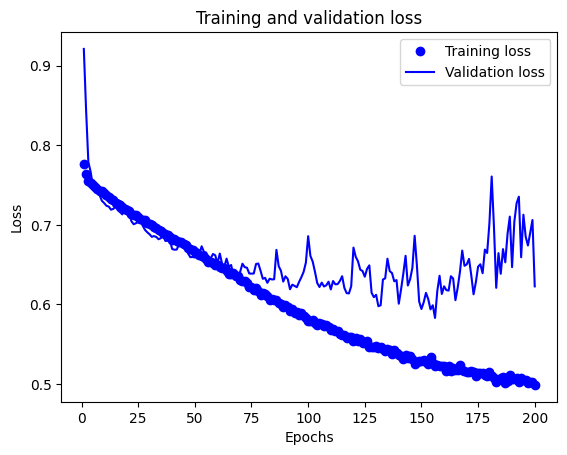

1/1 [==============================] - 0s 51ms/step
NN pred shape (18, 2)
Y Shape Uncollapsed (18, 2)
unedited preds
[[0.6581637  0.34183627]
 [0.609825   0.390175  ]
 [0.51418144 0.4858186 ]
 [0.22321111 0.7767889 ]
 [0.49081305 0.5091869 ]]
Y Shape Reshapen (18, 1)
[[0.9698909 ]
 [0.95859582]
 [1.09986988]
 [1.47522891]
 [1.50663388]]
Stat Preds
[[0.9698909  0.96861601]
 [0.95859582 0.95913672]
 [1.09986988 1.0886178 ]
 [1.47013061 1.47522891]
 [1.50722212 1.50663388]]
Real Ys
[[0.99294918]
 [0.99595652]
 [1.31173911]
 [1.47865089]
 [1.50822558]]
2
STAT VAL ENSEMBLE MSE:  0.0033541734922553756
NN VAL MODEL MSE:  0.003243907338741355
NN+STAT VAL ENSEMBLE MSE:  0.003313954979316786


(0.0033541734922553756, 0.003243907338741355, 0.003313954979316786)

In [ ]:
# Hyper parameters
L1=0
L2=1e-3
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=20)




full_single_nn_wrapper2(
    "feedforward",
    "classification",
    0.8,
    "SPY",
    model_names = ['auto_arima','complex_smoothing'],
    predReturnFunctions = [new_aaPredFunction, new_cesPredFunction],
    start_date_in = '2023-12-25',
    end_date_in = '2024-02-15',
    interval_in = '5m',
    split = False,
    train_size = 2000,
    train_window = 30,
    test_window = 1,
    verbose = 1)

In [ ]:
"""full_test = prep_ticker('QQQ', intervals = "5m", start_date = '2023-12-15', end_date = '2024-01-30', split = False)

print(np.mean(full_test, axis = 0))

full_test = (full_test - np.mean(full_test, axis = 0) ) / np.std(full_test ,axis = 0)

print(full_test.head)"""

full_test = prep_ticker('SPY', intervals = "5m", start_date = '2023-12-25', end_date = '2024-01-30', split = False)

full_test = full_test.diff()
print(np.mean(full_test, axis = 0))

full_test = (full_test - np.mean(full_test, axis = 0) ) / np.std(full_test ,axis = 0)

print(full_test.head)


[*********************100%%**********************]  1 of 1 completed

Close    0.009308
dtype: float64
<bound method NDFrame.head of                               Close
Datetime                           
2023-12-26 09:30:00-05:00       NaN
2023-12-26 09:35:00-05:00 -0.060254
2023-12-26 09:40:00-05:00  0.158100
2023-12-26 09:45:00-05:00 -0.060254
2023-12-26 09:50:00-05:00 -0.606044
...                             ...
2024-01-29 15:35:00-05:00 -0.715221
2024-01-29 15:40:00-05:00 -0.496962
2024-01-29 15:45:00-05:00 -0.450036
2024-01-29 15:50:00-05:00  0.251667
2024-01-29 15:55:00-05:00  1.935964

[1794 rows x 1 columns]>


In [ ]:
output = stat_true_window_cross_val(full_test, ['auto_arima','complex_smoothing'], [new_aaPredFunction, new_cesPredFunction], train_window= 20)

(107, 23)
(2262,)


In [ ]:
##sanity_check = np.array([1,2,3,4,5,6])

#xs,ys,preds = stat_true_window_cross_val(sanity_check, ['auto_arima','complex_smoothing'], [new_aaPredFunction, new_cesPredFunction], train_window= 5, test_window = 1)



(1, 8)
(6,)
[[1.         2.         3.         4.         5.         6.
  6.         3.77109623]]


In [ ]:

first_try_x = output[0:80,np.r_[0:10, 11:13]]
first_try_y = output[0:80, 10:11]

first_try_x_val = output[80:107,np.r_[0:10, 11:13]]
first_try_y_val = output[80:107, 10:11]

print(first_try_x.shape)
print(first_try_y.shape)

(80, 12)
(80, 1)


In [ ]:


"""L1=0
L2=1e-3

# create a sequential model once again
model = Sequential()
model.add(layers.Dense(32, activation='relu',input_shape=[12]))
# This layer is the recurent layer, which returns all previous data
model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))


# layer that reads the recurent layer
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')


test_one = model.fit(x = first_try_x, y = first_try_y, steps_per_epoch=150, epochs=20, batch_size = 1, validation_data= (first_try_x_val, first_try_y_val), validation_steps=60, verbose = 1)
"""

print(len(first_try_x))

# Hyper parameters
L1=0
L2=1e-3
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=5)


# create a sequential model once again
model = Sequential()
model.add(layers.Dense(32, activation='relu',input_shape=[12,]))
# This layer is the recurent layer, which returns all previous data
model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
#model.add(layers.Dropout(rate=0.25))
#model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))
#model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))


# layer that reads the recurent layer
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(learning_rate = 0.00001), loss='mse')


test_one = model.fit(x = first_try_x, y = first_try_y, steps_per_epoch = 80, epochs=150, batch_size = 1, validation_data= (first_try_x_val, first_try_y_val),callbacks=[callback], validation_steps=25, verbose = 1)


80
Epoch 1/150
80/80 [==============================] - 2s 12ms/step - loss: 1.2630 - val_loss: 1.1436
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 1.1412 - val_loss: 1.1157
Epoch 3/150
80/80 [==============================] - 0s 4ms/step - loss: 1.0294 - val_loss: 1.0837
Epoch 4/150
80/80 [==============================] - 0s 5ms/step - loss: 0.9234 - val_loss: 1.0533
Epoch 5/150
80/80 [==============================] - 0s 5ms/step - loss: 0.8274 - val_loss: 1.0219
Epoch 6/150
80/80 [==============================] - 0s 4ms/step - loss: 0.7413 - val_loss: 0.9864
Epoch 7/150
80/80 [==============================] - 0s 3ms/step - loss: 0.6530 - val_loss: 0.9519
Epoch 8/150
80/80 [==============================] - 0s 4ms/step - loss: 0.5724 - val_loss: 0.9161
Epoch 9/150
80/80 [==============================] - 0s 3ms/step - loss: 0.5048 - val_loss: 0.8792
Epoch 10/150
80/80 [==============================] - 0s 3ms/step - loss: 0.4381 - val_loss: 0.8468
Epoch

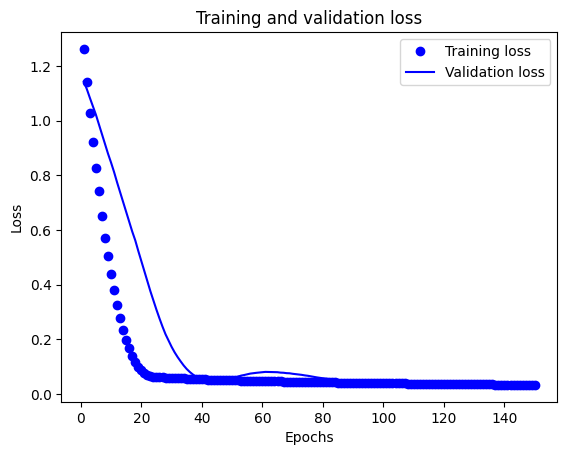

In [ ]:
history_plot(test_one)

In [ ]:
#print(model.predict(first_try_x))

nn_preds = model.predict(first_try_x)
stat_preds = first_try_x[:,10:12]
print(stat_preds[0:3,:])
print(first_try_x[0:3,:])
real_ys = first_try_y
window = 1

stat_avg_mse, nn_mse, nn_avg_mse = calculate_metrics(window, real_ys, stat_preds, nn_preds)

print("STAT TRAIN ENSEMBLE MSE: ", stat_avg_mse)
print("NN TRAIN MODEL MSE: ", nn_mse)
print("NN+STAT TRAIN ENSEMBLE MSE: ", nn_avg_mse)


nn_preds2 = model.predict(first_try_x_val)
stat_preds2 = first_try_x_val[:,10:12]
print(stat_preds2[0:3,:])
real_ys2 = first_try_y_val
window2 = 1

stat_avg_mse, nn_mse, nn_avg_mse = calculate_metrics(window, real_ys2, stat_preds2, nn_preds2)

print("STAT VAL ENSEMBLE MSE: ", stat_avg_mse)
print("NN VAL MODEL MSE: ", nn_mse)
print("NN+STAT VAL ENSEMBLE MSE: ", nn_avg_mse)

3/3 [==============================] - 0s 15ms/step
[[-1.02839118 -1.00976611]
 [-1.02246525 -1.00636658]
 [-1.26201821 -1.25186096]]
[[-1.18837558 -1.17737103 -1.121501   -1.17059781 -1.10056137 -1.18244965
  -1.15197791 -1.10795973 -1.08849253 -1.09441329 -1.02839118 -1.00976611]
 [-1.01821843 -1.00215076 -0.98268356 -0.98776218 -1.01653933 -1.02669658
  -1.04955297 -1.05378429 -1.02502265 -1.06055752 -1.02246525 -1.00636658]
 [-1.13081612 -1.13165825 -1.1214855  -1.13335285 -1.09780248 -1.07409879
  -1.07071476 -1.14556118 -1.26370764 -1.20784277 -1.26201821 -1.25186096]]
2
STAT TRAIN ENSEMBLE MSE:  0.002580036183811661
NN TRAIN MODEL MSE:  0.0034495044041024624
NN+STAT TRAIN ENSEMBLE MSE:  0.0020458753035366454
1/1 [==============================] - 0s 19ms/step
[[-0.36473955 -0.30719559]
 [ 0.03647174  0.04324496]
 [ 0.36326026  0.37759717]]
2
STAT VAL ENSEMBLE MSE:  0.002839849369788067
NN VAL MODEL MSE:  0.008564990617821129
NN+STAT VAL ENSEMBLE MSE:  0.0020829388950082527


In [ ]:
cv_data2 = cv_data[1:120]

cv_data2[0:12] = np.array([0,1,2,3,4,5,6,7,8,9,10,11]).reshape([12,1])
output = stat_true_window_cross_val(cv_data2, ['auto_arima','complex_smoothing'], [new_aaPredFunction, new_cesPredFunction])

NameError: name 'cv_data' is not defined

In [ ]:
print(output[0:3,0:13])
print(cv_data[0:12])

In [ ]:
testResultsQQQ, trainSeriesQQQ, testSeriesQQQ = prep_ticker('QQQ')

print(testResultsQQQ.head() )
print(trainSeriesQQQ.head() )
print(testSeriesQQQ.head() )

[*********************100%%**********************]  1 of 1 completed

        Price  auto_arima  dyn_theta  auto_ets  complex_smoothing
0  376.239990           0          0         0                  0
1  377.880005           0          0         0                  0
2  378.390015           0          0         0                  0
3  378.799988           0          0         0                  0
4  379.730011           0          0         0                  0


In [ ]:
testResultsQQQ, trainSeriesQQQ, testSeriesQQQ = prep_ticker('QQQ', model_list = ['auto_arima', 'dyn_theta', 'complex_smoothing'])



NameError: name 'yf' is not defined

In [ ]:
qqqpreds, qqqerrors = stat_test_wrapper(trainSeriesQQQ, testSeriesQQQ, testResultsQQQ, 200, 10)
